In [1]:
# Importing libraries
import os
import cv2
import torch
import config
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations
import matplotlib.pyplot as plt

from tqdm import tqdm
from train import train
from source.network import ConvRNN
from utils import load_obj, save_obj
from source.dataset import TRSynthDataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
# Get the number of training epochs from the configuration
epochs = config.epochs

# Get the batch size for training from the configuration
batch_size = config.batch_size

# Get the file path for saving the trained model from the configuration
model_path = config.model_path

# Get the file path for the character-to-integer mapping from the configuration
char2int_path = config.char2int_path

# Get the file path for the integer-to-character mapping from the configuration
int2char_path = config.int2char_path

# Get the file path for the training data from the configuration
data_file_path = config.data_file_path

# Get the file path for the image data from the configuration
image_path = config.image_path

# Get the file path for the label data from the configuration
label_path = config.label_path


### Inspect some images

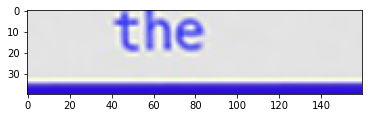

In [11]:
# Construct the complete file path by joining "00000017.jpg" with the directory specified in image_path
img = plt.imread(os.path.join(image_path, "00000017.jpg"))

# Display the loaded image
plt.imshow(img)

plt.show()


---

### Check corresponding label

In [6]:
# Read data from the text file specified by label_path into a Pandas DataFrame
labels = pd.read_table(label_path, header=None)


In [7]:
labels.head()

,0
0,life
1,not
2,while
3,know
4,clearly


In [8]:
# Access the value at the 17th row (index 17) and the first column (index 0) in the 'labels' DataFrame
value = labels.iloc[17, 0]


'the'

In [9]:
labels.shape

(100000, 1)

---

### Total number of images

In [10]:
# Get the number of files in the directory specified by 'image_path'
len(os.listdir(image_path))


100000

### Find null values in labels

In [12]:
# Checking null values
labels.isna().sum()

0    2
dtype: int64

In [13]:
# Select rows in the 'labels' DataFrame where the value in the first column (column 0) is NaN (missing)
labels[labels[0].isna()]


,0
19198,NaN
74347,NaN


---

### Let's check those images

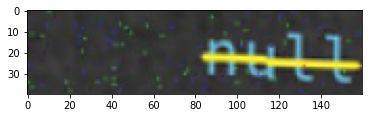

In [14]:
# Load and display the image "00019198.jpg" located in the directory
img = plt.imread(os.path.join(image_path, "00019198.jpg"))

# Display the loaded image
plt.imshow(img)

plt.show()


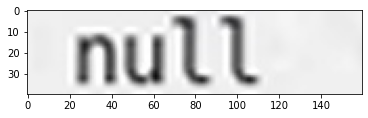

In [15]:
# Load the image "00074347.jpg" located in 'image_path'
img = plt.imread(os.path.join(image_path, "00074347.jpg"))

# Display the loaded image
plt.imshow(img)

plt.show()


---

### Replace those missing values with the string "null"

In [16]:
labels.fillna("null", inplace=True)

### Create a dataframe with image paths and corresponding labels

In [18]:
# List files in the 'image_path' directory
image_files = os.listdir(image_path)

# Sort the list of image file names alphabetically
image_files.sort()

# Create a list of full file paths by joining 'image_path' and each file name
image_files = [os.path.join(image_path, i) for i in image_files]


In [19]:
# Create a DataFrame with 'images' and 'labels' columns
data_file = pd.DataFrame({"images": image_files, "labels": labels[0]})

# Save the DataFrame to a CSV file at 'data_file_path'
data_file.to_csv(data_file_path, index=False)


In [20]:
data_file.head()

,images,labels
0,data/TRSynth100K/images/00000000.jpg,life
1,data/TRSynth100K/images/00000001.jpg,not
2,data/TRSynth100K/images/00000002.jpg,while
3,data/TRSynth100K/images/00000003.jpg,know
4,data/TRSynth100K/images/00000004.jpg,clearly


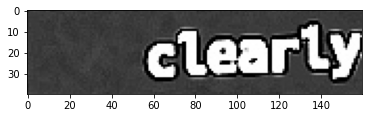

In [21]:
# Load the image "00000004.jpg" located in 'image_path'
img = plt.imread(os.path.join(image_path, "00000004.jpg"))

# Display the loaded image
plt.imshow(img)

plt.show()


---

### Find the unique characters in the labels

In [22]:
# Create a set of unique characters from the labels in the first column of 'labels' DataFrame
unique_chars = list({l for word in labels[0] for l in word})

# Sort the list of unique characters alphabetically
unique_chars.sort()


In [23]:
unique_chars

['#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [24]:
len(unique_chars)

81

---

### Create mapping from characters to integer and integer to character and save them to disc

In [25]:
# Create a character-to-integer mapping using unique characters and their corresponding indices
char2int = {a: i+1 for i, a in enumerate(unique_chars)}

# Create an integer-to-character mapping using unique characters and their corresponding indices
int2char = {i+1: a for i, a in enumerate(unique_chars)}


In [26]:
save_obj(char2int, char2int_path)
save_obj(int2char, int2char_path)

---

# Training the model

In [27]:
# Use GPU ("cuda:0") if available; otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Split the data into train and validation

In [28]:
# Split the 'data_file' DataFrame into training and validation sets
train_file, valid_file = train_test_split(data_file, test_size=0.2)


### Create train and validation datasets

In [29]:
# Create training and validation datasets using 'train_file' and 'valid_file' with character-to-integer mapping 'char2int'
train_dataset = TRSynthDataset(train_file, char2int)
valid_dataset = TRSynthDataset(valid_file, char2int)


### Define the loss function

In [30]:
# Define the CTC loss criterion with sum reduction and move it to the specified device
criterion = nn.CTCLoss(reduction="sum")
criterion.to(device)


CTCLoss()

### Number of classes

In [31]:
n_classes = len(char2int)

### Create the model object

In [32]:
# Create a ConvRNN model with 'n_classes' output classes and move it to the specified device
model = ConvRNN(n_classes)
model.to(device)


ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

---

### Define Optimizer

In [33]:
# Define an RMSprop optimizer for the 'model' with a learning rate of 0.0005
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)


### Define train and validation data loaders

In [34]:
# Create data loaders for training and validation using the specified datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


### Training loop

In [ ]:
# Iterate through the specified number of epochs
for i in range(epochs):
    print(f"Epoch {i+1} of {epochs}...")
    
    # Run the training function and calculate the training loss
    train_loss = train(model, train_loader, criterion, device, optimizer, test=False)
    
    # Run the validation function and calculate the validation loss
    valid_loss = train(model, valid_loader, criterion, device, test=True)
    
    # Print the training and validation loss
    print(f"Train Loss: {round(train_loss, 4)}, Valid Loss: {round(valid_loss, 4)}")
    
    # Check if the validation loss is better than the best seen so far
    if valid_loss < best_loss:
        print("Validation Loss improved, saving Model File...")
        
        # Save the model's state to a file
        torch.save(model.state_dict(), model_path)
        best_loss = valid_loss


### Load the trained model

In [48]:
# Create a ConvRNN model
model = ConvRNN(n_classes)

# Load the model's state from the saved model file located at 'model_path'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model's mode to evaluation
model.eval()


ConvRNN(
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding

---

# Prediction

### Pick a test image

In [60]:
test_img = os.path.join(image_path, "00000017.jpg")
img = cv2.imread(test_img)

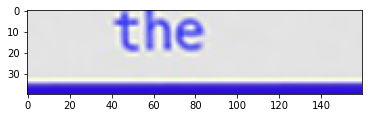

In [65]:
plt.imshow(plt.imread(test_img))
plt.show()

### Apply augmentations

In [43]:
# Define the mean and standard deviation for image normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Create an image augmentation pipeline to normalize the image
img_aug = albumentations.Compose([albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])

# Apply the image augmentation to 'img'
augmented = img_aug(image=img)
img = augmented["image"]

# Transpose the image dimensions for compatibility with PyTorch
img = img.transpose(2, 0, 1)

# Convert the image to a PyTorch tensor
img = torch.from_numpy(img)

# Add a batch dimension to create a batch of a single image
img = torch.unsqueeze(img, 0)

# Move the image tensor to the specified device (e.g., GPU if available)
img = img.to(device)


### Take model output

In [49]:
# Pass the image 'img' through the 'model' to obtain an output prediction
out = model(img)


/opt/anaconda3/envs/ppro/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


---

### Apply softmax and take label predictions

In [50]:
# Remove the batch dimension to get a single output
out = torch.squeeze(out, 0)

# Apply softmax to the output to get class probabilities
out = out.softmax(1)

# Get the predicted class label by selecting the index with the highest probability
pred = torch.argmax(out, 1)


In [51]:
pred.shape

torch.Size([40])

In [52]:
pred = pred.tolist()

In [53]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75,
 0,
 0,
 63,
 0,
 0,
 0,
 60,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [54]:
int2char[75]

't'

### Use 'ph' for special character

In [55]:
int2char[0] = "ph"

### Convert integer predictions to string

In [57]:
# Convert the predicted class indices 'pred' into corresponding characters using 'int2char'
out = [int2char[i] for i in pred]


In [58]:
out

['ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 't',
 'ph',
 'ph',
 'h',
 'ph',
 'ph',
 'ph',
 'e',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph',
 'ph']

### Collapse the output

In [66]:
# Initialize a result list and add the first character from 'out'
res = list()
res.append(out[0])

# Iterate through 'out' to remove consecutive duplicate characters and exclude "ph" characters
for i in range(1, len(out)):
    if out[i] != out[i - 1]:
        res.append(out[i])

# Filter out "ph" characters from the result list
res = [i for i in res if i != "ph"]

# Convert the filtered list to a single string
res = "".join(res)


In [67]:
print(res)

the


---